In [1]:
import jax
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from functools import partial
import random

# Rapid intro to supervised learning with neural nets I: from scratch

This notebook gives a rapid introduction to supervised learning with neural networks. The example is based on [Chapter 1 of Nielsen's online book "Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/chap1.html) and it guides you to set up the neural network training completely from scratch.

For further reading I recommend also the review article ["A high-bias, low-variance introduction to Machine Learning for physicists"](https://arxiv.org/abs/1803.08823).

We also employ JAX functionality, in particular, [vectorization](https://jax.readthedocs.io/en/latest/jax.html?highlight=vmap#vectorization-vmap) and [random numbers](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html?highlight=random).

**Notice:** In order to use JAX function transformations (like vectorization) we have to replace the Numpy library with its JAX version, which has the same interface. For example, instead of `np.array` all our arrays will be `jnp.array`s. The same for functions, e.g. instead of `np.dot` we have to use `jnp.dot` for the dot-product.

## The MNIST hand-written digits data set

Let's first get a simple exemplary data set - the MNIST hand-written digits. The following cell downloads both the test and training parts of the data set.

In [2]:
trainData = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, shuffle_files=False))['image'].reshape(-1,28,28)
trainLabels = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, shuffle_files=False))['label']

testData = tfds.as_numpy(tfds.load('mnist', split='test', batch_size=-1, shuffle_files=False))['image'].reshape(-1,28,28)
testLabels = tfds.as_numpy(tfds.load('mnist', split='test', batch_size=-1, shuffle_files=False))['label']

`trainData` is now a Numpy array of shape `(60000,28,28)`, meaning that we have 60k images of 28$\times$28 pixels (grayscale), each showing one hand-written digit. `trainLabels` holds the corresponding *labels*, i.e. an integer for each image, stating which digit it shows.

Let's have a look at some examples:

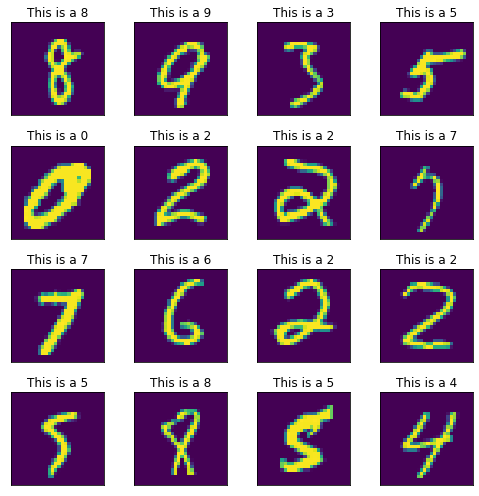

In [3]:
fig,axs = plt.subplots(4,4,figsize=(7,7))

for ax_row in axs:
    for ax in ax_row:
        idx = random.randint(0,60000)
        ax.imshow(trainData[idx])
        ax.set_title("This is a %d" % (trainLabels[idx]))
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

Our goal is now to train a neural network, which takes the images as input, and processes them in such a way as to tell us which digit it is. For this purpose, we can take a supervised learning approach, because we have a *labeled data set*, where we know for each example the answer we would like the neural network to give.

Formally, we would like to find a function $f$, which maps every training sample $x^{(j)}$ to the corresponding label $y^{(j)}$:

$$y^{(j)}=f(x^{(j)})$$

## Neural networks

Neural networks are constructed as alternating sequences of affine-linear and non-linear maps. Therefore, it is natural to talk about *layers* as building blocks. The output of the $l$-th layer is a vector of *activations* $\mathbf{a}^{(l)}\equiv(a_1^{(l)},\ldots,a_{N_l}^{(l)})$ and $N_l$ is the *width* of the $l$-th layer. This output is obtained by processing the activations of the previous layer by an affine-linear map followed by a non-linear map:

$$a_i^{(l)} = \sigma\bigg(\sum_j W_{ij}^{(l)}a_j^{(l-1)}+b_j^{(l)}\bigg)$$

Here the **weights** $W_{ij}^{(l)}$ are the entries of a $N_l\times N_{l-1}$-matrix and $b_j^{(l)}$ are $N_l$ **biases**. $\sigma$ is some non-linear function. A common choice is the *sigmoid* function:



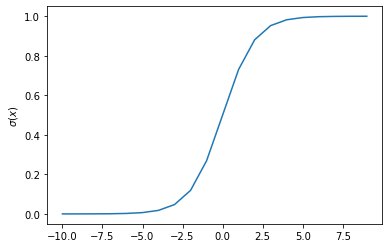

In [4]:
def sigmoid(x):
    return 1. / (1. + jnp.exp(-x))

plt.plot(np.arange(-10.,10.),sigmoid(np.arange(-10,10)))
plt.ylabel(r"$x$")
plt.ylabel(r"$\sigma(x)$");

A neural network layer is commonly represented graphically as follows:

<img src="figures/ann_layer.png" style="width:450px;">

A neural network is a function constructed from neural network layers by stacking them on top of each other. The input is interpreted as the activations of the $0$-th layer:

$$\mathbf{a}^{(0)}(\mathbf{x}) = \mathbf{x}$$

The activations in the following layers, $\mathbf{a}^{(l)}(\mathbf{x})$, are obtained accordin to the iterative prescription given above. The resulting activations of the last layer, $\mathbf{a}^{(D)}$ constitute the output of the neural network. Therefore, a neural network is a function

$$f_\theta:\mathbf x\mapsto f_\theta(\mathbf x)$$

Here $\theta$ denotes the **parameters** of the network, i.e., the set of all weights and biases.

Remarkably, neural networks are **universal function approximators** in the limit of infinite depth, $D\to\infty$, or width, $N_l\to\infty$. This means that by choosing the right parameters $\theta$ the function $f_\theta$ can arbitrarily accurately approximate any function, if the network is only big enough. *Therefore, we can be optimistic to find also a set of parameters $\theta$ such that the neural network maps our images of hand-written digits to the corresponding digit.*

But first, let us set up our neural network:

In [5]:
def initialize_network(dimensions, seed=123):
    '''This is a helper function to get a set of random initial parameters for a given network size.
    The size is given as a list of widths, one width for each layer.
    Args:
    * `dimensions`: List of layer widths.
    * `seed`: PRNG seed.
    Returns:
    A dictionary holding a list of "weights" and a list of "biases", where each entry 
    is the weight matrix/bias vector of the respective layer.
    '''

    rndKey = jax.random.PRNGKey(seed)
    
    params={"weights": [], "biases": []}
    
    for j in range(len(dimensions)-1):
        rndKey, key1 = jax.random.split(rndKey)
        weights=0.01*jax.random.normal(rndKey, (dimensions[j+1],dimensions[j]))
        biases=jnp.zeros(dimensions[j+1])
        
        params["weights"].append(weights)
        params["biases"].append(biases)
        
    return params

@partial(jax.vmap, in_axes=(None,0)) # This decorator vectorizes the function
def neural_network(params, x):
    '''This function evaluates the neural network with the given parameters.
    Args:
    * `params`: Neural network parameters
    * `x`: Input image.
    Returns: Obtained activations of the last layer.
    '''
    
    a = x.ravel() # flatten input and assign it to the activations of the zeroth layer
    
    # ! evaluate the network
    for W,b in zip(params["weights"],params["biases"]):
        a = sigmoid(jnp.dot(W,a) + b)

    # ! return activations of last layer
    return a

Now we are set to see what the network thinks about our images of digits.

Clearly, there are some constraints on the network size for this purpose. The width of the first layer has to match the number of pixels in the images ($28\times28$). Also, we would like to have ten numbers as output - the network is supposed to indicate its answer ($0-9$) through the maximum value of the ten outputs. In addition we introduce one intermediate layer of width $N_1=100$.

*Remark: here you might get a warning regarding the absence of GPUs. No reason to be concerned.*

In [6]:
# ! Get random parameters for the desired network size (28*28,100,10)
params = initialize_network((28*28,100,10))

# ! Evaluate the network on the first three examples in our data set
neural_network(params, jnp.array(trainData[0:3]))

DeviceArray([[0.48719582, 0.48804665, 0.48642933, 0.47404566, 0.49631682,
              0.5150176 , 0.5044507 , 0.48679698, 0.47715867, 0.53815067],
             [0.4971365 , 0.5067497 , 0.47718787, 0.46895266, 0.5179492 ,
              0.50581676, 0.5067713 , 0.48855644, 0.4615775 , 0.5175387 ],
             [0.49860272, 0.48288807, 0.49253824, 0.46893996, 0.52591544,
              0.50971645, 0.5106837 , 0.4829083 , 0.4768304 , 0.5086878 ]],            dtype=float32)

## Cost function

Now, how can we find parameters $\theta$ that allow our neural network to do the job? How can our network *learn* to predict the correct labels for the input images? For this purpose we set up a *cost function* that defines the objective and quantifies how well the neural network solves the task.

$$\mathcal L_{\mathcal T}(\theta)=\frac{1}{|\mathcal T|}\sum_{(x,y)\in \mathcal T}\big(y-f_\theta(x)\big)^2$$

Here, $\mathcal T$ denotes the training data set.

Our network gives ten numbers as output ($f_\theta^r(x)$ for $r=0\ldots 9$) and we would like to interpret it such that the index of the maximal output indicates the digit shown in the input image. Therefore, we rewrite the cost function as

$$\mathcal L_{\mathcal T}(\theta)=\frac{1}{|\mathcal T|}\sum_{(x,y)\in \mathcal T}\sum_{r=0}^9\big(\delta_{r,y}-f_\theta^r(x)\big)^2$$

In [7]:
def cost_function(predictions, labels):
    '''This function evaluates the cost function for given predictions and labels
    Args:
    * `predictions`: Predictions from neural net. Array of shape $|\mathcal T|$ x 10.
    * `labels`: Correct labels for the corresponding images. Array of $|\mathcal T|$ integers.
    Returns: Cost associated with the neural network predictions for the given data.
    '''

    labels = jax.nn.one_hot(labels, 10) # get one-hot encoding of labels
    cost = jnp.sum((predictions-labels)**2)

    return cost / labels.shape[0]

With this, we can check the performance of our randomly initialized network in classifying some of our images:

In [8]:
batch = trainData[:128]    # select a batch of images
labels = trainLabels[:128] # and corresponding labels

# ! compute neural network predictions
predictions = neural_network(params,batch)

# ! evaluate the cost function
cost_function(predictions,labels)

DeviceArray(2.4789789, dtype=float32)

## Stochastic gradient descent and backpropagation

You saw above that our network does not do particularly well yet in classifying the digits. We now have to **train** it and the basic idea is to do **gradient-based optimization** to minimize the cost function.

Generally, we can attempt to minimize the cost function using gradient descent, an iterative procedure where in each step the parameter update
$$\theta^{(j+1)}\leftarrow\theta^{(j)}-\eta\nabla_\theta\mathcal L_{\mathcal T}(\theta^{(j)})$$
is performed with some **learning rate** $\eta$. This way, we can reduce the loss until we reach a stationary state with $\nabla_\theta\mathcal L(\theta)=0$. Unfortunately, however, the cost landscape $\mathcal L_{\mathcal T}(\theta)$ is highly non-convex, meaning that it typically comprises an abundant number of local minima and saddle points. Plain gradient descent is prone to getting stuck in very these sub-optimal stationary points.

This is one reason why neural networks are in practice trained using **stochastic gradient descent** (SGD) or some more sophisticated variants of it. The term *stochastic* refers to the fact that in each step gradients of the cost function are computed only on a small randomly chosen subset of the full training set $\mathcal B_j\subset\mathcal T$. These subsets $\mathcal B_j$ are called **(mini-)batches** and the SGD update rule for step number $j$ is
$$\theta^{(j+1)}\leftarrow\theta^{(j)}-\eta\nabla_\theta\mathcal L_{\mathcal B_j}(\theta^{(j)})$$
The stochastic noise introduced in this way enables us to avoid getting stuck in saddle points and to overcome *cost barries* such that we ultimately reach better minima. Besides that, the batch-wise evaluation of gradients has practical advantages, because typical data sets of interest in machine learning often exceed the available memory capacities, such that computing gradients on the full data set would be extremely costly.

But how do we compute these gradients? In fact, this can be done very efficiently thanks to the layered structure of neural networks, which allows us to use the **backpropagation** algorithm. Backpropagation is essentially based on the observation that knowing the gradients of the cost function with respect to activations in the $l+1$-th layer enables us to very easily compute gradients of the cost function with respect to activations in the $l$-th layer because of the chain rule:

$$\frac{\partial\mathcal L_{\mathcal B}}{\partial a_i^{(l)}}=\sum_j\frac{\partial\mathcal L_{\mathcal B}}{\partial a_j^{(l+1)}}\frac{\partial a_j^{(l+1)}}{\partial a_i^{(l)}}$$

To write down the backpropagation rules for our fully connected neural network, we introduce, moreover, the pre-activations

$$z_i^{(l)}=\sum_j W_{ij}^{(l)}a_j^{(l-1)}+b_j^{(l)}$$

which are related to the activations via $a_i^{(l)}=\sigma\big(z_i^{(l)}\big)$. Including the pre-activations, we can write derivatives of the cost function w.r.t. our variational parameters $W_{ij}^{(l)}$ and $b_j^{(l)}$ as

$$\frac{\partial\mathcal L_{\mathcal B}}{\partial W_{ij}^{(l)}}=\sum_k\frac{\partial\mathcal L_{\mathcal B}}{\partial 
z_k^{(l)}}\frac{\partial z_k^{(l)}}{\partial W_{ij}^{(l)}}=\frac{\partial\mathcal L_{\mathcal B}}{\partial z_i^{(l)}}a_j^{(l-1)}$$
and
$$\frac{\partial\mathcal L_{\mathcal B}}{\partial b_{i}^{(l)}}=\sum_k\frac{\partial\mathcal L_{\mathcal B}}{\partial z_k^{(l)}}\frac{\partial z_k^{(l)}}{\partial b_{i}^{(l)}}=\frac{\partial\mathcal L_{\mathcal B}}{\partial z_i^{(l)}}$$

Therefore, we introduce

$$\Delta_j^{(D)}=\frac{\partial\mathcal L_{\mathcal B}}{\partial z_j^{(D)}}\equiv\frac{\partial\mathcal L_{\mathcal B}}{\partial a_j^{(D)}}\sigma'\big(z_j^{(D)}\big)\\
\Delta_j^{(l)}=\frac{\partial\mathcal L_{\mathcal B}}{\partial z_j^{(l)}}=
\sum_k\frac{\partial\mathcal L_{\mathcal B}}{\partial z_k^{(l+1)}}\frac{\partial z_k^{(l+1)}}{\partial z_j^{(l)}}=\sum_k
\Delta_k^{(l+1)}W_{kj}^{(l+1)}\sigma'(z_j^{(l)})
$$

Here $\sigma'(\cdot)$ denotes the derivative of the non-linearity $\sigma(\cdot)$. The last four equations give us the prescription to obtain the gradients of the cost function as follows:

1. Perform a *forward evaluation* of the network and keep the activations $a_j^{(l)}$ as well as the pre-activations $z_j^{(l)}$ in memory.
2. Perform a *backward pass* to iteratively obtain the $\Delta_j^{(l)}$, and at each step compute the gradients with respect to the variational parameters in the corresponding layer.

Notice that due to the linearity of the gradient we can first compute the per-sample gradients $\nabla_\theta\mathcal L_{\{x\}}(\theta)$ for all $x\in\mathcal B$ and then obtain the mini-batch gradient as

$$\nabla_\theta\mathcal L_{\mathcal B}(\theta)=\sum_{x\in\mathcal B}\nabla_\theta\mathcal L_{\{x\}}(\theta)$$

In [9]:
def sigmoid_deriv(x):
    ''' This function evaluates the derivative of the sigmoid non-linearity.
    Args:
    * `x`: Float.
    Returns: $\sigma'(x)$
    '''
    # ! compute and return the derivative of the sigmoid function
    y = sigmoid(x)
    return y * (1-y)

@partial(jax.vmap, in_axes=(None,0,0)) # This decorator vectorizes the function
def cost_function_individual_gradients(params, x, label):
    '''This function defines the per-sample gradient computed by backpropagation.
    Args:
    * `params`: Neural network parameters
    * `x`: Input image (2D array).
    * `label`: Label associated with the input image.
    Returns:
    Gradient of the cost function for the given sample.
    '''
    
    label = jax.nn.one_hot(label, 10) # get one-hot encoding of label
    
    a = x.ravel() # flatten input
    # Set up storage space for (pre-)activations
    a_list = [a]
    z_list = []
    
    # FORWARD PASS
    # ! forward evaluation of the network, storing (pre-)activations
    for W,b in zip(params["weights"],params["biases"]):
        
        z = jnp.dot(W,a) + b
        a = sigmoid(z)
        
        z_list.append(z)
        a_list.append(a)

    # BACKWARD PASS
    # Set up storage space for gradients (layer-wise)
    weight_gradients = [jnp.zeros_like(w) for w in params["weights"]]
    bias_gradients = [jnp.zeros_like(b) for b in params["biases"]]
    
    # ! Apply backpropagation rules for top layer
    Delta = 2*(a_list[-1]-label) * sigmoid_deriv(z_list[-1])
    
    weight_gradients[-1] = jnp.outer(Delta, a_list[-2])
    bias_gradients[-1] = Delta
    
    for l in range(2,len(a_list)):
        
        # ! Apply backpropagation rules

        z = z_list[-l]
        sp = sigmoid_deriv(z)
        Delta = jnp.dot(jnp.transpose(params["weights"][-l+1]), Delta) * sp

        weight_gradients[-l] = jnp.outer(Delta, a_list[-l-1])
        bias_gradients[-l] = Delta
        
    return {"weights": weight_gradients, "biases": bias_gradients}


def cost_function_gradients(params, samples, labels):
    '''This function computes the gradients for a given mini-batch of data.
    Args:
    * `params`: Neural network parameters.
    * `samples`: Batch of training images.
    * `labels`: Labels corresponding to the given images.
    Returns:
    Gradients of the cost function evaluated on the mini-batch of training data.
    '''
    
    # Evaluate individual gradients
    grads = cost_function_individual_gradients(params, samples, labels)
    
    # Sum up gradients
    for j in range(len(params["weights"])):
        grads["weights"][j] = jnp.sum(grads["weights"][j], axis=0)
        grads["biases"][j] = jnp.sum(grads["biases"][j], axis=0)
    
    return grads



## Training and test data sets

You saw that above we loaded `trainData` as well as `testData`. The reason for this is that we would like to test the performance of our trained network on examples that it has not seen before. This check tells us how well the network *learned to generalize* from the examples in our training data. Moreover, we want to avoid that our network learns to solve the task by exploiting specific features that are only present in our training data set (*overfitting*). Once the network starts to overfit, the cost achieved on the test data set (**test error**) grows as training progresses, i.e. the generalization quality deteriorates. Therefore, it is important to monitor the test error during training.

## Training loop

We are not ready to compose the training loop from all the pieces defined above. Each iteration of the loop is called an **epsiode**. In each episode, the training data set is shuffled and split into equally sized **(mini-)batches**. Then the gradients are computed sequentially for each mini-batch and the parameters of the neural network are updated according to the SGD update rule.

After completion of each episode we assess the performance of the network by evaluating the cost function on the test data set and, in addition, by counting how many of the images in the test data set are classified correctly.

In [10]:
def evaluate_predictions(predictions, labels):
    '''This is a helper function that counts how many of the given predictions match the labels.
    Args:
    * `predictions`: Predictions from neural network (=activations on output layer)
    * `labels`: correct labels
    Returns: Number of correct predictions, i.e., number of cases, in which the index of the maximal 
    activation matches the given label.
    '''
    
    pred_labels = jnp.argmax(predictions, axis=1)

    return jnp.where(pred_labels==labels)[0].shape[0]


# Get a key for the PRNG
prng_key = jax.random.PRNGKey(123)

# Here we define the hyperparamters
num_epochs = 10 # Number of epochs to loop over
learning_rate = 0.001 # Learning rate
batch_size = 128 # Size of mini-batches

# Compute the number of mini-batches that matches the chosen mini-batch size
batch_number = trainData.shape[0] // batch_size

# Evaluate network and assess performance
predictions = neural_network(params, testData)
current_cost = cost_function(neural_network(params, testData), testLabels)
correct_predictions = evaluate_predictions(predictions, testLabels)
print("Initial cost: %f" % (current_cost))
print("Correctly predicted labels: %d / %d" % (correct_predictions, len(testLabels)))

# Training loop over epochs
for n in range(num_epochs):
    
    print("Episode %d" % (n))
    
    # Generate batches from randomly permuted data
    prng_key, tmp_key = jax.random.split(prng_key) # jax-style treatment of random numbers
    batches = (jax.random.permutation(tmp_key, trainData)[:batch_number*batch_size].reshape(-1,128,28,28), 
               jax.random.permutation(tmp_key, trainLabels)[:batch_number*batch_size].reshape(-1,128))
    
    # Loop over mini-batches
    for samples, labels in zip(*batches):

        # compute gradients
        grads = cost_function_gradients(params, samples, labels)
        
        # Perform SGD parameter update step
        for j in range(len(params["weights"])):
            params["weights"][j] -= learning_rate * grads["weights"][j]
            params["biases"][j] -= learning_rate * grads["biases"][j]

    # Evaluate network and assess performance
    predictions = neural_network(params, testData)
    current_cost = cost_function(predictions, testLabels)
    correct_predictions = evaluate_predictions(predictions, testLabels)
    print("Current cost: %f" % (current_cost))
    print("Correctly predicted labels: %d / %d" % (correct_predictions, len(testLabels)))

Initial cost: 2.478697
Correctly predicted labels: 830 / 10000
Episode 0
Current cost: 0.237248
Correctly predicted labels: 8948 / 10000
Episode 1
Current cost: 0.201171
Correctly predicted labels: 9009 / 10000
Episode 2
Current cost: 0.178127
Correctly predicted labels: 9085 / 10000
Episode 3
Current cost: 0.168678
Correctly predicted labels: 9087 / 10000
Episode 4
Current cost: 0.151855
Correctly predicted labels: 9188 / 10000
Episode 5
Current cost: 0.164609
Correctly predicted labels: 9117 / 10000
Episode 6
Current cost: 0.143876
Correctly predicted labels: 9184 / 10000
Episode 7
Current cost: 0.138300
Correctly predicted labels: 9208 / 10000
Episode 8
Current cost: 0.138404
Correctly predicted labels: 9213 / 10000
Episode 9
Current cost: 0.132524
Correctly predicted labels: 9248 / 10000
